# `beamforming`

In the `beamforming` module, some postprocessing and simulation algorithms are saved in order to allow for the experimentation with data from a microphone array.

So far, the available beamforming formulations for the frequency domain are:
- Delay-and-sum (or conventional beamforming)
- Clean-SC
- Orthogonal
- Functional
- MVDR (or Capon)

For the time domain, Delay-and-sum has been implemented.

For more formulations and parallel computing, see [acoular](http://acoular.org).

#### Basics
The necessary objects in order to obtain a beamforming result are: Grid, Microphone Array, Steering Vector, Beamforming formulation. For each of these, there is a dedicated object.

Furthermore, a source class called `MonopoleSource` is also provided for simulation purposes.

In [1]:
import dsptoolbox as dsp
from os.path import join

from pandas import read_xml
from numpy import arange

# Example: 2D-Grid, 2 Sources

### Get an array geometry

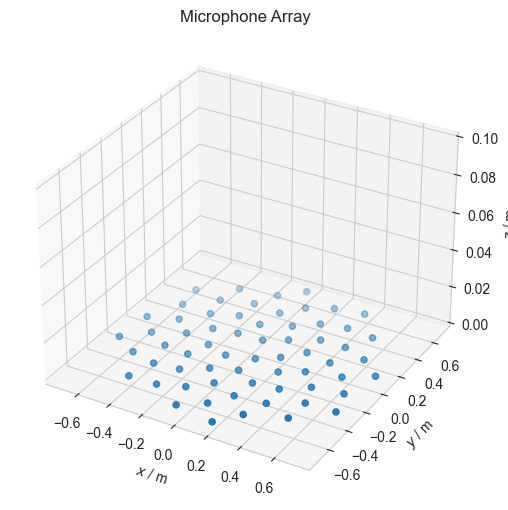

In [2]:
# Import an array geometry
array = read_xml(join('data', 'array.xml'))
array = dsp.beamforming.MicArray(array)

# Plot array
fig, ax = array.plot_points(projection='3d')
ax.set_title('Microphone Array')
ax.set_zlim([0, 0.1]);

### Simulate recorded multi-channel signal

In [3]:
source_1 = dsp.Signal(join('data', 'speech.flac'))
source_2 = dsp.Signal(join('data', 'chirp.wav'))

# Resample for a shorter computation time
source_1 = dsp.resample(source_1, 8_000)
source_2 = dsp.resample(source_2, 8_000)

# Simulate sources on the array
source_1 = dsp.beamforming.MonopoleSource(source_1, [0, 0, 1])
source_2 = dsp.beamforming.MonopoleSource(source_2, [-0.5, 0.5, 1])
recorded_signal = \
    dsp.beamforming.mix_sources_on_array([source_1, source_2], array)

/Users/neumanndev/opt/anaconda3/envs/dsp-dev11/lib/python3.11/site-packages/dsptoolbox/classes/signal_class.py:182: UserWarning: Signal was over 0 dBFS, normalizing to 0 dBFS peak level was triggered
  warn('Signal was over 0 dBFS, normalizing to 0 dBFS ' +
/Users/neumanndev/opt/anaconda3/envs/dsp-dev11/lib/python3.11/site-packages/dsptoolbox/beamforming/beamforming.py:1468: UserWarning: Emitted signals from sources differ in length. Trimming to shortest will be done
  warn('Emitted signals from sources differ in length. Trimming to '


### Create a grid

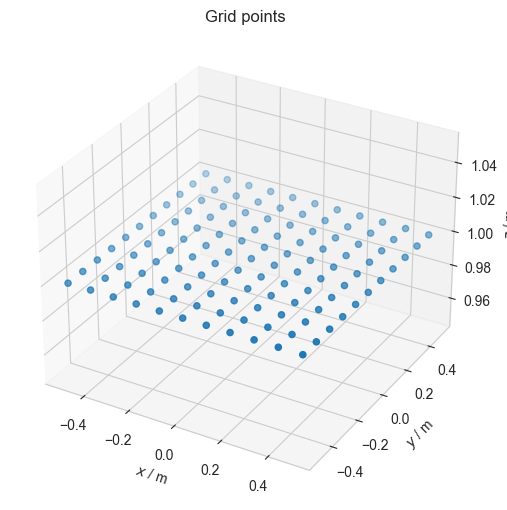

In [4]:
grid = dsp.beamforming.Regular2DGrid(arange(-0.5, 0.6, 0.1),
                                     arange(-0.5, 0.6, 0.1),
                                     dimensions=('x', 'y'),
                                     value3=1)
fig, ax = grid.plot_points(projection='3d')
ax.set_title('Grid points');

### Setup Beamformer

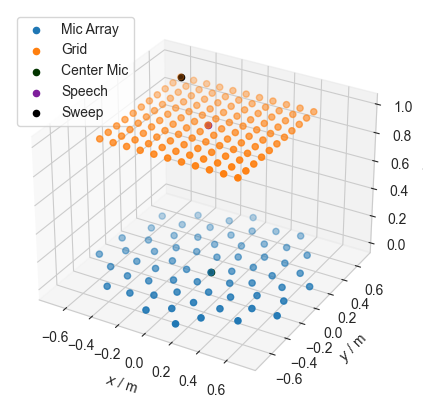

In [5]:
# Steering vector. There are 4 formulations by default, but own
# implementations can be passed
steering = dsp.beamforming.SteeringVector('true location')

beamformer = dsp.beamforming.BeamformerDASFrequency(
    multi_channel_signal=recorded_signal,
    mic_array=array,
    grid=grid,
    steering_vector=steering)
fig, ax = beamformer.plot_setting();
ax.scatter(source_1.coordinates[0], source_1.coordinates[1],
           source_1.coordinates[2], color='xkcd:purple', label='Speech')
ax.scatter(source_2.coordinates[0], source_2.coordinates[1],
           source_2.coordinates[2], color='xkcd:black', label='Sweep')
ax.legend(['Mic Array', 'Grid', 'Center Mic', 'Speech', 'Sweep']);

### Get result and plot


Beamformer computation has started successfully:
------------------------------------------------
...csm...
...Steering vector...
...Apply...


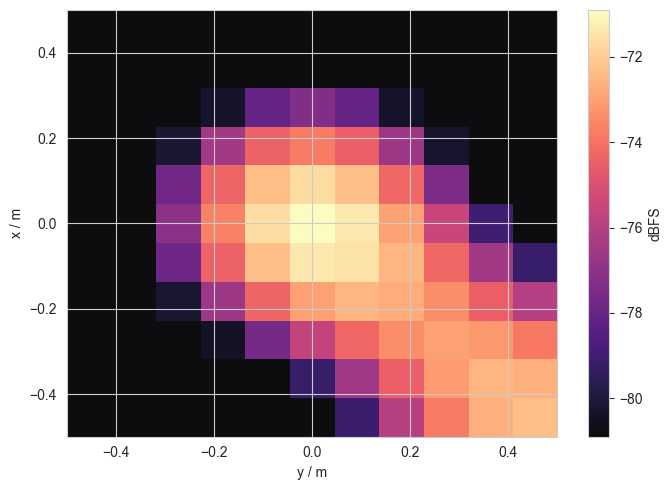

In [6]:
# Trigger computation in beamformer
bf_map = \
    beamformer.get_beamformer_map(center_frequency_hz=500, octave_fraction=3,
                                  remove_csm_diagonal=True)

# Use the grid object to plot the map
grid.plot_map(bf_map, range_db=10);

### Use another formulation

To improve the result, it is possible to take a higher-resolution beamformer. For instance, functional beamforming.

Note: once the CSM of the multi-channel signal has been computed, it is saved to avoid unnecessary computations. Unless new computation parameters are passed, it will not be calculated again.


Beamformer computation has started successfully:
------------------------------------------------
...csm...
...Steering vector...
...Apply...


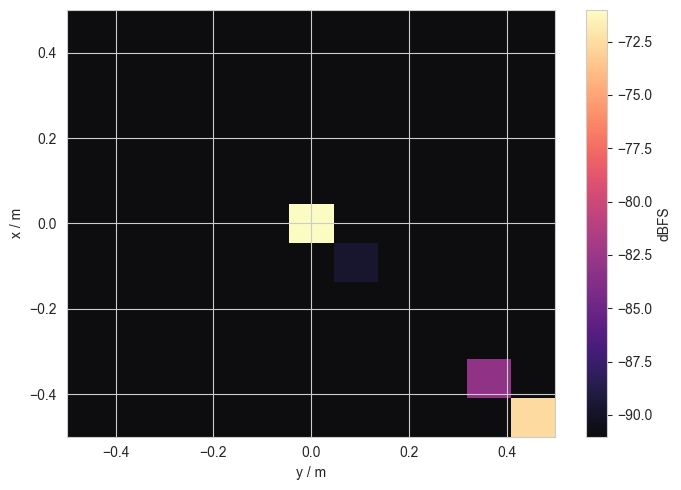

In [13]:
beamformer = \
    dsp.beamforming.BeamformerFunctional(recorded_signal,
                                         array, grid, steering)

# Trigger computation in beamformer
bf_map = \
    beamformer.get_beamformer_map(center_frequency_hz=500, octave_fraction=3,
                                  gamma=150)

# Use the grid object to plot the map
grid.plot_map(bf_map, range_db=20);